In [223]:

import matplotlib.pylab as plt
import numpy as np
from scipy.integrate import cumtrapz
from scipy.optimize import curve_fit

from matplotlib import rc
fontsize = 10
fontstyle = {
    "pdf.fonttype": 42, # type 3 pdf fonts
    "mathtext.default": 'regular', # italic math
    'mathtext.fontset': 'cm',
    'font.family' : 'STIXGeneral',
    "text.usetex": True, # latex-based math
    # sans-serif Helvetica font
    #"text.latex.preamble":
    #    r'\usepackage{helvet} \usepackage{sansmath} \sansmath',
    #"font.family": "sans-serif",
    # font sizes
    "axes.labelsize": fontsize,
    'axes.titlesize': fontsize,
    "font.size": fontsize,
    "legend.fontsize": fontsize,
    "xtick.labelsize": fontsize,
    'xtick.direction': "inout",
    'xtick.top': True,
    'xtick.major.size': 4,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    "ytick.labelsize": fontsize,
    'ytick.direction': "inout",
    'ytick.right': True,
    'ytick.major.size': 4,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    "axes.linewidth": 0.5,
}

plt.rcParams.update(fontstyle)

c = 3e8
eps0 = 8.85e-12
import sys
sys.path.append("../src")
from tweezer_force import Domain
from matplotlib import cm
from matplotlib.colors import Normalize


In [224]:
letters_lower = [r"$\mathrm{\bf{%s}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"]
letters_round = [r"$\mathrm{\bf{(%s)}}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz"] 
letters_upper = [r"$\bf{%s}$" % lett for lett in "abcdefghijklmnopqrstuvwxyz".upper()] 
letters_map = {"round": letters_round, "upper": letters_upper, "lower":letters_lower}  
def lettering(ax, x, y, num, color="k", mode="round", **kwargs):     
    letters = letters_map[mode]     
    ax.text(x, y, letters[num], weight="bold", transform=ax.transAxes,             
            horizontalalignment="center", verticalalignment="center", color=color, **kwargs)

In [151]:
import numpy as np
import math
from scipy.optimize import curve_fit

def gauss(x, sigma, mu):
    return np.exp(-2*(x-mu)**2 / (sigma**2))


def fit_gauss(x, y, sigma0=1, mu0=0):
    popt, pcov = curve_fit(gauss, x, y, p0=[sigma0, mu0])
    perr = np.sqrt(np.diag(pcov))
    return popt, perr


#https://blockgeni.com/rotating-image-by-any-angle-using-numpy/
def shear(angle,x,y):
    '''
    |1  -tan(𝜃/2) |  |1        0|  |1  -tan(𝜃/2) | 
    |0      1     |  |sin(𝜃)   1|  |0      1     |

    '''
    # shear 1
    tangent=math.tan(angle/2)
    new_x=round(x-y*tangent)
    new_y=y
    
    #shear 2
    new_y=round(new_x*math.sin(angle)+new_y)      #since there is no change in new_x according to the shear matrix

    #shear 3
    new_x=round(new_x-new_y*tangent)              #since there is no change in new_y according to the shear matrix
    
    return new_y,new_x



def rotate_data(image, angle):
    angle=-int(angle)
    # Define the most occuring variables
    angle=math.radians(angle)                               #converting degrees to radians
    cosine=math.cos(angle)
    sine=math.sin(angle)

    height=image.shape[0]                                   #define the height of the image
    width=image.shape[1]                                    #define the width of the image

    # Define the height and width of the new image that is to be formed
    new_height  = round(abs(image.shape[0]*cosine)+abs(image.shape[1]*sine))+1
    new_width  = round(abs(image.shape[1]*cosine)+abs(image.shape[0]*sine))+1

    # define another image variable of dimensions of new_height and new _column filled with zeros
    output=np.zeros((new_height,new_width))
    image_copy=output.copy()


    # Find the centre of the image about which we have to rotate the image
    original_centre_height   = round(((image.shape[0]+1)/2)-1)    #with respect to the original image
    original_centre_width    = round(((image.shape[1]+1)/2)-1)    #with respect to the original image

    # Find the centre of the new image that will be obtained
    new_centre_height= round(((new_height+1)/2)-1)        #with respect to the new image
    new_centre_width= round(((new_width+1)/2)-1)          #with respect to the new image


    for i in range(height):
        for j in range(width):
            #co-ordinates of pixel with respect to the centre of original image
            y=image.shape[0]-1-i-original_centre_height                   
            x=image.shape[1]-1-j-original_centre_width 

            #Applying shear Transformation                     
            new_y,new_x=shear(angle,x,y)

            '''since image will be rotated the centre will change too, 
                so to adust to that we will need to change new_x and new_y with respect to the new centre'''
            new_y=new_centre_height-new_y
            new_x=new_centre_width-new_x
        
            output[new_y,new_x]=image[i,j]                          #writing the pixels to the new destination in the output image
    return output

In [185]:
class Pinhole:
    def __init__(self, basename):
        self.names = ["F", "B", "x", "y", "z"]
        self.labels = {"F": "Forward", "B":"Backward", "diff": "B-F", "ratio":"B/F", "I": "Intensity (arb.)"}
        self.labels.update({c : f"{c}-axis" for c in "xyz"})
        scan_dat = {}
        self.shape = []
        for name in self.names:
            dat = np.fromfile(basename + "_" + name + ".dat", dtype='>d')
            if name in ("F", "B"):
                scan_dat[name] = dat
            else:
                dat *= 20 / 75
                self.shape.append(len(dat))
                setattr(self, name, dat)
        for name, dat in scan_dat.items():
            dat = dat.reshape(self.shape) / dat.max()
            #dat = np.flip(dat, axis=0)
            maxdex = np.unravel_index(np.argmax(dat, axis=None), dat.shape)
            setattr(self, name, dat)
            setattr(self, f"{name}maxdex", maxdex)
    
    @property
    def Nx(self):
        return len(self.x)
    
    @property
    def Ny(self):
        return len(self.y)
    
    @property
    def Nz(self):
        return len(self.z)
    
    @property
    def axes(self):
        return [self.x, self.y, self.z]
    
    @property
    def beams(self):
        return [self.F, self.B]
    
    def shift_axes(self, beam="F"):
        self.x -= self.x[getattr(self, beam+ "maxdex")[0]]
        self.y -= self.y[getattr(self, beam+ "maxdex")[1]]
        self.z -= self.z[getattr(self, beam+ "maxdex")[2]]
    
    
    def axis(self, c):
        assert c in ("x", "y", "z")
        return getattr(self, c)
    
    def beam(self, c):
        assert c in ("F", "B", "diff", "ratio")
        if c in ("F", "B"):
            return getattr(self, c)
        elif c == "diff":
            return self.B - self.F
        elif c == "ratio":
            return self.B/self.F
    
    def extent(self, c1, c2):
        ax1 = getattr(self, c1)
        ax2 = getattr(self, c2)
        return [ax1[0], ax1[-1], ax2[0], ax2[-1]]
    
    
    def plot_2d(self, c1="y", c2="z", c3i=None, beams="FB", norm=True, axs=None, 
                unit="um", cbar=False, angle=0, contour=False, **kwargs):
        c3 = np.setdiff1d([c for c in "xyz"], [c1, c2])[0]
        c1pos = "xyz".index(c1)
        c2pos = "xyz".index(c2)
        c3pos = "xyz".index(c3)
        if c3i is None:
            c3i = int(self.shape[c3pos] / 2)
        if axs is None:
            fig, axs = plt.subplots(1, len(beams))
            if len(beams) == 1:
                axs = [axs]
        else:
            fig = plt.gcf()

        slc = [slice(N) for N in self.shape]
        slc[c3pos] = c3i
        slc = tuple(slc)
        c3val = self.axes[c3pos][c3i]
        extent = self.extent(c1, c2)
        if unit == "V":
            extent = [e*75/20 for e in extent]

        
        for beam, ax in zip(np.atleast_1d(beams), np.atleast_1d(axs)):
            dat = self.beam(beam)[slc]
            if angle != 0:
                dat = rotate_data(dat, angle)
            if c1 < c2:
                dat = dat.T
            im = ax.imshow(dat, extent=extent, origin="lower", **kwargs)
            if contour:
                ax.contour(dat, levels=4, extent=extent, origin="lower", colors="k", linewidths=0.5, )
            if cbar:
                plt.colorbar(im)
            ax.set_title(self.labels[beam]+f", {c3}={round(c3val,1)} {unit}")
            ax.set_xlabel(self.labels[c1] + f" ({unit})")
            ax.set_ylabel(self.labels[c2]+ f" ({unit})")
        plt.tight_layout()
        return axs
        
    def plot_1d(self, c1="z", c2i=None, c3i=None, beams="FB", norm=True, ax=None, legend=True, fit=False, **kwargs):
        c2, c3 = np.setdiff1d([c for c in "xyz"], [c1])
        c1pos = "xyz".index(c1)
        c2pos = "xyz".index(c2)
        c3pos = "xyz".index(c3)
        if c2i is None:
            c2i = int(self.shape[c2pos] / 2)
        if c3i is None:
            c3i = int(self.shape[c3pos] / 2)
        if ax is None:
            fig, ax = plt.subplots(1, 1)
        else:
            fig = plt.gcf()

        slc = [slice(N) for N in self.shape]
        slc[c2pos] = c2i
        slc[c3pos] = c3i
        slc = tuple(slc)
        axis = self.axes[c1pos]
        popts, perrs = [], []
        for beam in beams:
            dat = self.beam(beam)[slc]
            if norm:
                ax.plot(axis, dat/np.max(dat), label=self.labels[beam], **kwargs)
            else:
                ax.plot(axis, dat, label=self.labels[beam], **kwargs)
            if fit:
                popt, perr = fit_gauss(axis, dat/np.max(dat))
                popts.append(popt)
                perrs.append(perr)
        ax.set_xlabel(self.labels[c1])
        ax.set_ylabel(self.labels["I"])
        if legend:
            ax.legend()
        if fit:
            return ax, popts, perrs
        else:
            return ax


In [186]:
basename ="/mnt/ext/data/pinhole_scan/pinhole_scan_20210706_full"
ph = Pinhole(basename)
ph.shift_axes("F")

import cmasher as cmr

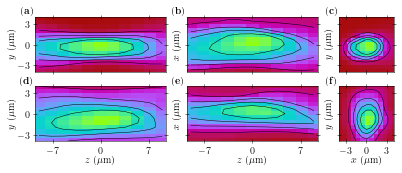

In [187]:
from matplotlib.gridspec import GridSpec
fig, axs = plt.subplots(2,3, figsize=(5.5, 2.3), sharex="col",
                        sharey=True, gridspec_kw={"width_ratios":[9.5, 9.5, 4]})
cmap = cmr.neon
contour = True
ph.plot_2d("x", "z", y0i, beams=["F"], norm=False, cmap=cmap, cbar=False, axs=axs[0,0], interpolation="none", contour=contour)
ph.plot_2d("x", "y", z0i, beams=["F"], norm=False, cmap=cmap, cbar=False, axs=axs[0,1], interpolation="none", contour=contour)
ph.plot_2d("y", "z", x0i, beams=["F"], norm=False, cmap=cmap, cbar=False, axs=axs[0,2], interpolation="none", contour=contour)

ph.plot_2d("x", "z", y0i, beams=["B"], norm=False, cmap=cmap, cbar=False, axs=axs[1,0], interpolation="none", contour=contour)
ph.plot_2d("x", "y", z0i, beams=["B"], norm=False, cmap=cmap, cbar=False, axs=axs[1,1], interpolation="none", contour=contour)
ph.plot_2d("y", "z", x0i, beams=["B"], norm=False, cmap=cmap, cbar=False, axs=axs[1,2], interpolation="none", contour=contour)

i = 0
for axr in axs:
    for ax in axr:
        ax.set_title(None)
        ax.set_ylim(-4,4)
        ax.set_yticks([-3,0,3])
        if i not in (2, 5):
            lettering(ax, -0.07, 1.1, i)
        i+=1
        for im in ax.get_images():
            im.set_clim(0,1)

for r in (0, 1):
    for c in (0, 1):
        axs[r,c].set_xticks([-7,0,7])
        axs[r,c].set_xlim(-9.5,9.5)

lettering(axs[0,2], -0.13, 1.1, 2)
lettering(axs[1,2], -0.13, 1.1, 5)
axs[0,2].set_xlim(-4,4)
axs[1,2].set_xlim(-4,4)
        
axs[0,2].set_xticks([-3,0,3])
axs[1,2].set_xticks([-3,0,3])
        
for ax in axs[0]:
    ax.set_xlabel("")

    
axs[0,0].set_ylabel(r"$y~(\rm \mu m)$", labelpad=0)
axs[1,0].set_ylabel(r"$y~(\rm \mu m)$", labelpad=0)
    
    
axs[0,1].set_ylabel(r"$x~(\rm \mu m)$", labelpad=5)
axs[1,1].set_ylabel(r"$x~(\rm \mu m)$", labelpad=5)
    
axs[0,2].set_ylabel(r"$y~(\rm \mu m)$", labelpad=5)
axs[1,2].set_ylabel(r"$y~(\rm \mu m)$", labelpad=5)

axs[1,0].set_xlabel(r"$z~(\rm \mu m)$", labelpad=0)
axs[1,1].set_xlabel(r"$z~(\rm \mu m)$", labelpad=0)
axs[1,2].set_xlabel(r"$x~(\rm \mu m)$", labelpad=0)
   
    
plt.subplots_adjust(left=0.075, right=0.98, top=0.95, bottom=0.15, wspace=0.2, hspace=0.1)
#plt.tight_layout()
plt.savefig("figures/dissertation/pinhole_slices.pdf", dpi=600)

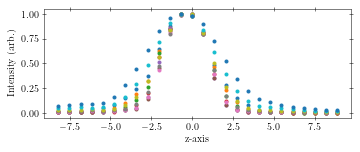

In [217]:
fig, ax = plt.subplots(1,1, figsize=(5.5,2), sharey=True, sharex=True)
w0s = []
for i in range(ph.Nx): 
    _, popts, perrs = ph.plot_1d(c1="z", c2i=i, c3i=12, beams="F", ax=ax,
                             norm=True, legend=False, fit=True, marker="o", ms=3, ls="none")
    w0s.append(popts[0][0])

In [218]:
w0s

[3.3414921532275206,
 3.1142335493658373,
 2.917151540720052,
 2.73626661641946,
 2.613717407866091,
 2.555642154474232,
 2.5888177051433763,
 2.733693433201525,
 3.1067939005656235,
 3.795628391297013,
 4.662612535122576]

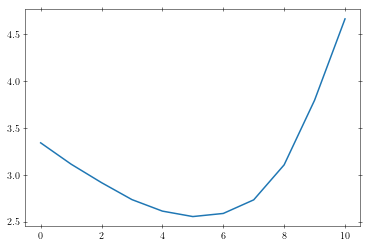

In [221]:
plt.plot(w0s)

y waist, (F, B) [(2.3905077705218303, 0.03761791661396789), (4.306540076540582, 0.13855809194297825)]
y pos, (F, B) [(-0.38444842039565913, 0.02302776181758981), (-0.44559702976105375, 0.0848368309871635)]

x waist, (F, B) [(3.5642809537776734, 0.10622650321504432), (3.337725507182055, 0.04878138154321294)]
x pos, (F, B) [(0.12862980522896614, 0.06506284421144384), (0.15249310236958924, 0.029880387499461866)]


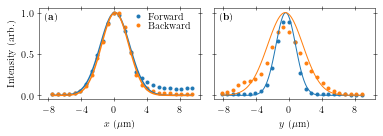

In [222]:
fig, axs = plt.subplots(1,2, figsize=(5.5,2), sharey=True, sharex=True)

_, popts, perrs = ph.plot_1d(c1="z", c2i=None, c3i=None, beams="FB", ax=axs[1],
                             norm=False, legend=False, fit=True, marker="o", ms=3, ls="none")
zs = np.linspace(ph.axes[2][0], ph.axes[2][-1], 100)
axs[1].plot(zs, gauss(zs, *popts[0]), color="C0", lw=1)
axs[1].plot(zs, gauss(zs, *popts[1]), color="C1", lw=1)
print("y waist, (F, B)", [(popt[0], perr[0]) for popt, perr in zip(popts, perrs)])
print("y pos, (F, B)", [(popt[1], perr[1]) for popt, perr in zip(popts, perrs)])

_, popts, perrs = ph.plot_1d(c1="y", c2i=None, c3i=None, beams="FB", ax=axs[0],
                             norm=True, legend=False, fit=True, marker="o", ms=3, ls="none")
ys = np.linspace(ph.axes[1][0], ph.axes[1][-1], 100)
axs[0].plot(ys, gauss(ys, *popts[0]), color="C0")
axs[0].plot(ys, gauss(ys, *popts[1]), color="C1")
axs[1].set_ylabel("")
axs[1].set_xlabel(r"$z~(\rm \mu m)$")
axs[0].set_xlabel(r"$y~(\rm \mu m)$")
axs[0].set_xticks([-8, -4, 0, 4, 8])
axs[0].legend(frameon=False, handletextpad=0, labelspacing=0, loc="upper right", 
              bbox_to_anchor=(1.0,1.05))
print()
print("x waist, (F, B)", [(popt[0], perr[0]) for popt, perr in zip(popts, perrs)])
print("x pos, (F, B)", [(popt[1], perr[1]) for popt, perr in zip(popts, perrs)])
    
axs[1].set_xlabel(r"$y~(\rm \mu m)$", labelpad=5)
axs[0].set_xlabel(r"$x~(\rm \mu m)$", labelpad=5)
plt.tight_layout()
lettering(axs[0], 0.07, 0.9, 0)
lettering(axs[1], 0.07, 0.9, 1)
plt.savefig("figures/dissertation/pinhole_transverse_lines.pdf", dpi=600)

In [190]:
popts

[array([3.56428095, 0.12862981]), array([3.33772551, 0.1524931 ])]

In [183]:
perrs

[array([0.1062265 , 0.06506284]), array([0.04878138, 0.02988039])]

In [209]:
#https://stackoverflow.com/questions/37327308/add-alpha-to-an-existing-matplotlib-colormap
import matplotlib
def rgb_white2alpha(rgb, ensure_increasing=False):
    # The most transparent alpha we can use is given by the min of RGB
    # Convert it from saturation to opacity
    alpha = 1. - np.min(rgb, axis=1)
    if ensure_increasing:
        # Let's also ensure the alpha value is monotonically increasing
        a_max = alpha[0]
        for i, a in enumerate(alpha):
            alpha[i] = a_max = np.maximum(a, a_max)
    alpha = np.expand_dims(alpha, -1)
    # Rescale colors to discount the white that will show through from transparency
    rgb = (rgb + alpha - 1) / alpha
    # Concatenate our alpha channel
    return np.concatenate((rgb, alpha), axis=1)
    

def cmap_white2alpha(name, ensure_increasing=True):
    # Fetch the cmap callable
    cmap = plt.get_cmap(name)
    # Get the colors out from the colormap LUT
    rgb = cmap(np.arange(cmap.N))[:, :3]  # N-by-3
    # Convert white to alpha
    rgba = rgb_white2alpha(rgb, ensure_increasing=ensure_increasing)
    # Create a new Colormap object
    cmap_alpha = matplotlib.colors.ListedColormap(rgba, name=name + "_alpha")
    return cmap_alpha

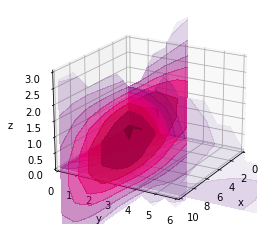

In [249]:
basename ="H:\\data\\pinhole_scan\\pinhole_scan_20210706_full"
ph = Pinhole(basename)
from copy import copy

clip = 0.1

axes = copy(ph.axes)
for i, axis in enumerate(axes):
    axes[i] -= axes[i][ph.Fmaxdex[i]]

cmap = cmap_white2alpha("PuRd")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

z0 = axes[2][ph.Fmaxdex[2]]
y0 = axes[1][ph.Fmaxdex[1]]
x0 = axes[0][ph.Fmaxdex[0]]


X, Y = np.meshgrid(axes[0], axes[1], indexing="ij")

dat = copy(ph.F[:,:,ph.Fmaxdex[2]])
dat[dat<clip] = np.nan
dat[Y<y0]=np.nan
dat[X<x0]=np.nan
ax.contourf(X, Y, dat, 10, zdir='z', offset=z0, cmap=cmap)

X, Z = np.meshgrid(axes[0], axes[2], indexing="ij")
dat = copy(ph.F[:,ph.Fmaxdex[1],:])
dat[dat<clip] = np.nan
#dat[Z<z0]=np.nan
#dat[X<x0]=np.nan
ax.contourf(X, dat, Z, 10, zdir='y', offset=y0, cmap=cmap)

Y, Z = np.meshgrid(axes[1], axes[2], indexing="ij")

dat = copy(ph.F[ph.Fmaxdex[0],:,:])
dat[dat<clip] = np.nan
dat[Y<y0]=np.nan
dat[Z<z0]=np.nan
ax.contourf(dat, Y, Z, 10, zdir='x', offset=x0, cmap=cmap)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_ylim(0,6)
ax.set_zlim(0,3)
ax.set_xlim(0,10)

ax.view_init(elev=20, azim=30)



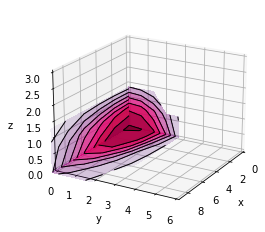

In [298]:
basename ="H:\\data\\pinhole_scan\\pinhole_scan_20210706_full"
ph = Pinhole(basename)
from copy import copy

clip = 0.26

N=8

axes = copy(ph.axes)
for i, axis in enumerate(axes):
    axes[i] -= axes[i][ph.Fmaxdex[i]]

cmap = cmap_white2alpha("PuRd")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

z0 = axes[2][ph.Fmaxdex[2]]
y0 = axes[1][ph.Fmaxdex[1]]
x0 = axes[0][ph.Fmaxdex[0]]

X, Y = np.meshgrid(axes[0], axes[1], indexing="ij")

dat = copy(ph.F[:,:,ph.Fmaxdex[2]])
dat[dat<clip] = np.nan
dat[Y<y0]=np.nan
dat[X<x0]=np.nan
ax.contourf(X, Y, dat, N, zdir='z', offset=z0, cmap=cmap)
ax.contour(X, Y, dat, N, zdir='z', offset=z0, colors="k", linewidths=1)

X, Z = np.meshgrid(axes[0], axes[2], indexing="ij")
dat = copy(ph.F[:,ph.Fmaxdex[1],:])
dat[dat<clip] = np.nan
dat[Z<z0]=np.nan
dat[X<x0]=np.nan
ax.contourf(X, dat, Z, N, zdir='y', offset=y0, cmap=cmap)
ax.contour(X, dat, Z, N, zdir='y', offset=y0, colors="k", linewidths=1)

Y, Z = np.meshgrid(axes[1], axes[2], indexing="ij")
dat = copy(ph.F[ph.Fmaxdex[0],:,:])
dat[dat<clip] = np.nan
dat[Y<y0]=np.nan
dat[Z<z0]=np.nan
ax.contourf(dat, Y, Z, N, zdir='x', offset=x0, cmap=cmap)
ax.contour(dat, Y, Z, N, zdir='x', offset=x0, colors="k", linewidths=1)


ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_ylim(0,6)
ax.set_zlim(0,3)
ax.set_xlim(0,9)

ax.view_init(elev=20, azim=30)



In [307]:
ph.extent

<bound method Pinhole.extent of <__main__.Pinhole object at 0x0000019F2BBF2A58>>

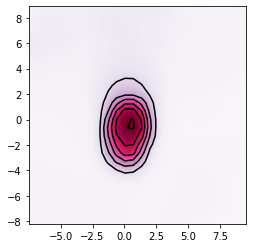

In [322]:
plt.imshow(ph.F[ph.Fmaxdex[0],:, :], interpolation="gaussian", cmap=cmap, extent=ph.extent("y","z"), origin="lower")
plt.contour(ph.F[ph.Fmaxdex[0],:, :], colors="k", extent=ph.extent("y","z"), origin="lower")

C:\Users\Starscream\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:92: UserWarning: Attempting to set identical bottom == top == 9.890666666666668 results in singular transformations; automatically expanding.


array([<AxesSubplot:title={'center':'Forward, x=0.0 um'}, xlabel='y-axis (um)', ylabel='z-axis (um)'>,
       <AxesSubplot:title={'center':'Backward, x=0.0 um'}, xlabel='y-axis (um)', ylabel='z-axis (um)'>],
      dtype=object)

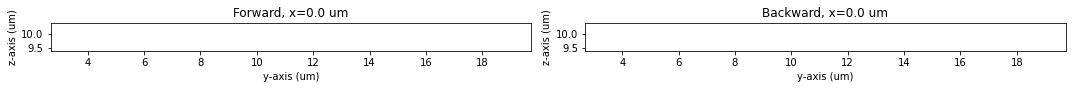

In [20]:
basename ="H:\\data\\pinhole_scan\\pinhole_scan_20210706_2"
ph = Pinhole(basename)
fig, axs = plt.subplots(1,2, figsize=(15,8))
ph.plot_2d("y", "z", 0, norm=False, cbar=False, axs=axs)

y x z
y x z
y x z
y x z
y x z
y x z
y x z
y x z


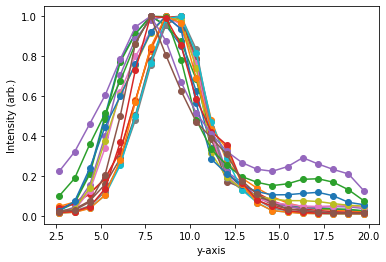

In [9]:
fig, ax = plt.subplots(1,1)
for xi in range(ph.Nx):
    ph.plot_1d("y", xi, 0, marker="o", ax=ax, legend=False)
#plt.savefig(r"C:\Users\Starscream\Desktop\wire_selection\pinhole\x-center.png", bbox_inches="tight")

y x z


<AxesSubplot:xlabel='y-axis', ylabel='Intensity (arb.)'>

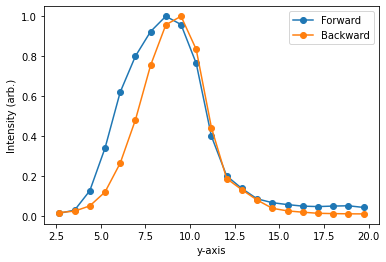

In [10]:
ph.plot_1d("y", ph.Fmaxdex[0], ph.Fmaxdex[2], marker="o")

z x y


<AxesSubplot:xlabel='z-axis', ylabel='Intensity (arb.)'>

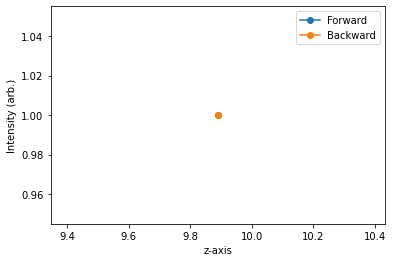

In [11]:
ph.plot_1d("z", ph.Fmaxdex[0], ph.Fmaxdex[1], marker="o")
#plt.savefig(r"C:\Users\Starscream\Desktop\wire_selection\pinhole\z-center.png", bbox_inches="tight")

In [12]:
np.array(ph.extent("x", "y"))*70/20

array([ 0.        , 69.00133333,  9.38933333, 69.05733333])

array([<AxesSubplot:title={'center':'Forward, y=9.9 um'}, xlabel='x-axis (um)', ylabel='z-axis (um)'>,
       <AxesSubplot:title={'center':'Backward, y=9.9 um'}, xlabel='x-axis (um)', ylabel='z-axis (um)'>],
      dtype=object)

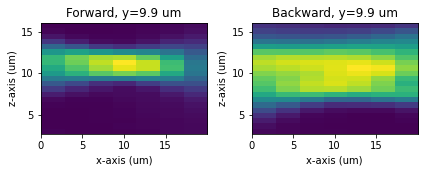

In [13]:
basename ="H:\\data\\pinhole_scan\\pinhole_scan_20210716_xz"
ph3 = Pinhole(basename)
ph3.plot_2d("x", "z", 0, norm=False, unit="um")